In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools

# create Ground truth

In [2]:
pip install geopandas

     |████████████████████████████████| 931kB 4.5MB/s 
     |████████████████████████████████| 10.4MB 12.7MB/s 
     |████████████████████████████████| 14.7MB 319kB/s 


In [0]:
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
import geopandas

In [0]:
longitude = np.random.uniform(size=40)*10
latitude = np.random.uniform(size=40)*10
df_temp = pd.DataFrame()
df_temp['longitude'] = longitude
df_temp['latitude'] = latitude
df_temp['coordinate'] = df_data[['longitude','latitude']].values.tolist()
df_temp['coordinate'] = df_data['coordinate'].apply(Point)
points = df_temp['coordinate'].values

In [0]:
true_class = np.vstack((np.ones((16,1)), 2*np.ones((16,1)),3*np.ones((8,1))))
true_class = true_class.astype(int).flatten()
color = ['g','b','r']
color_array = [color[c-1] for c in true_class]

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

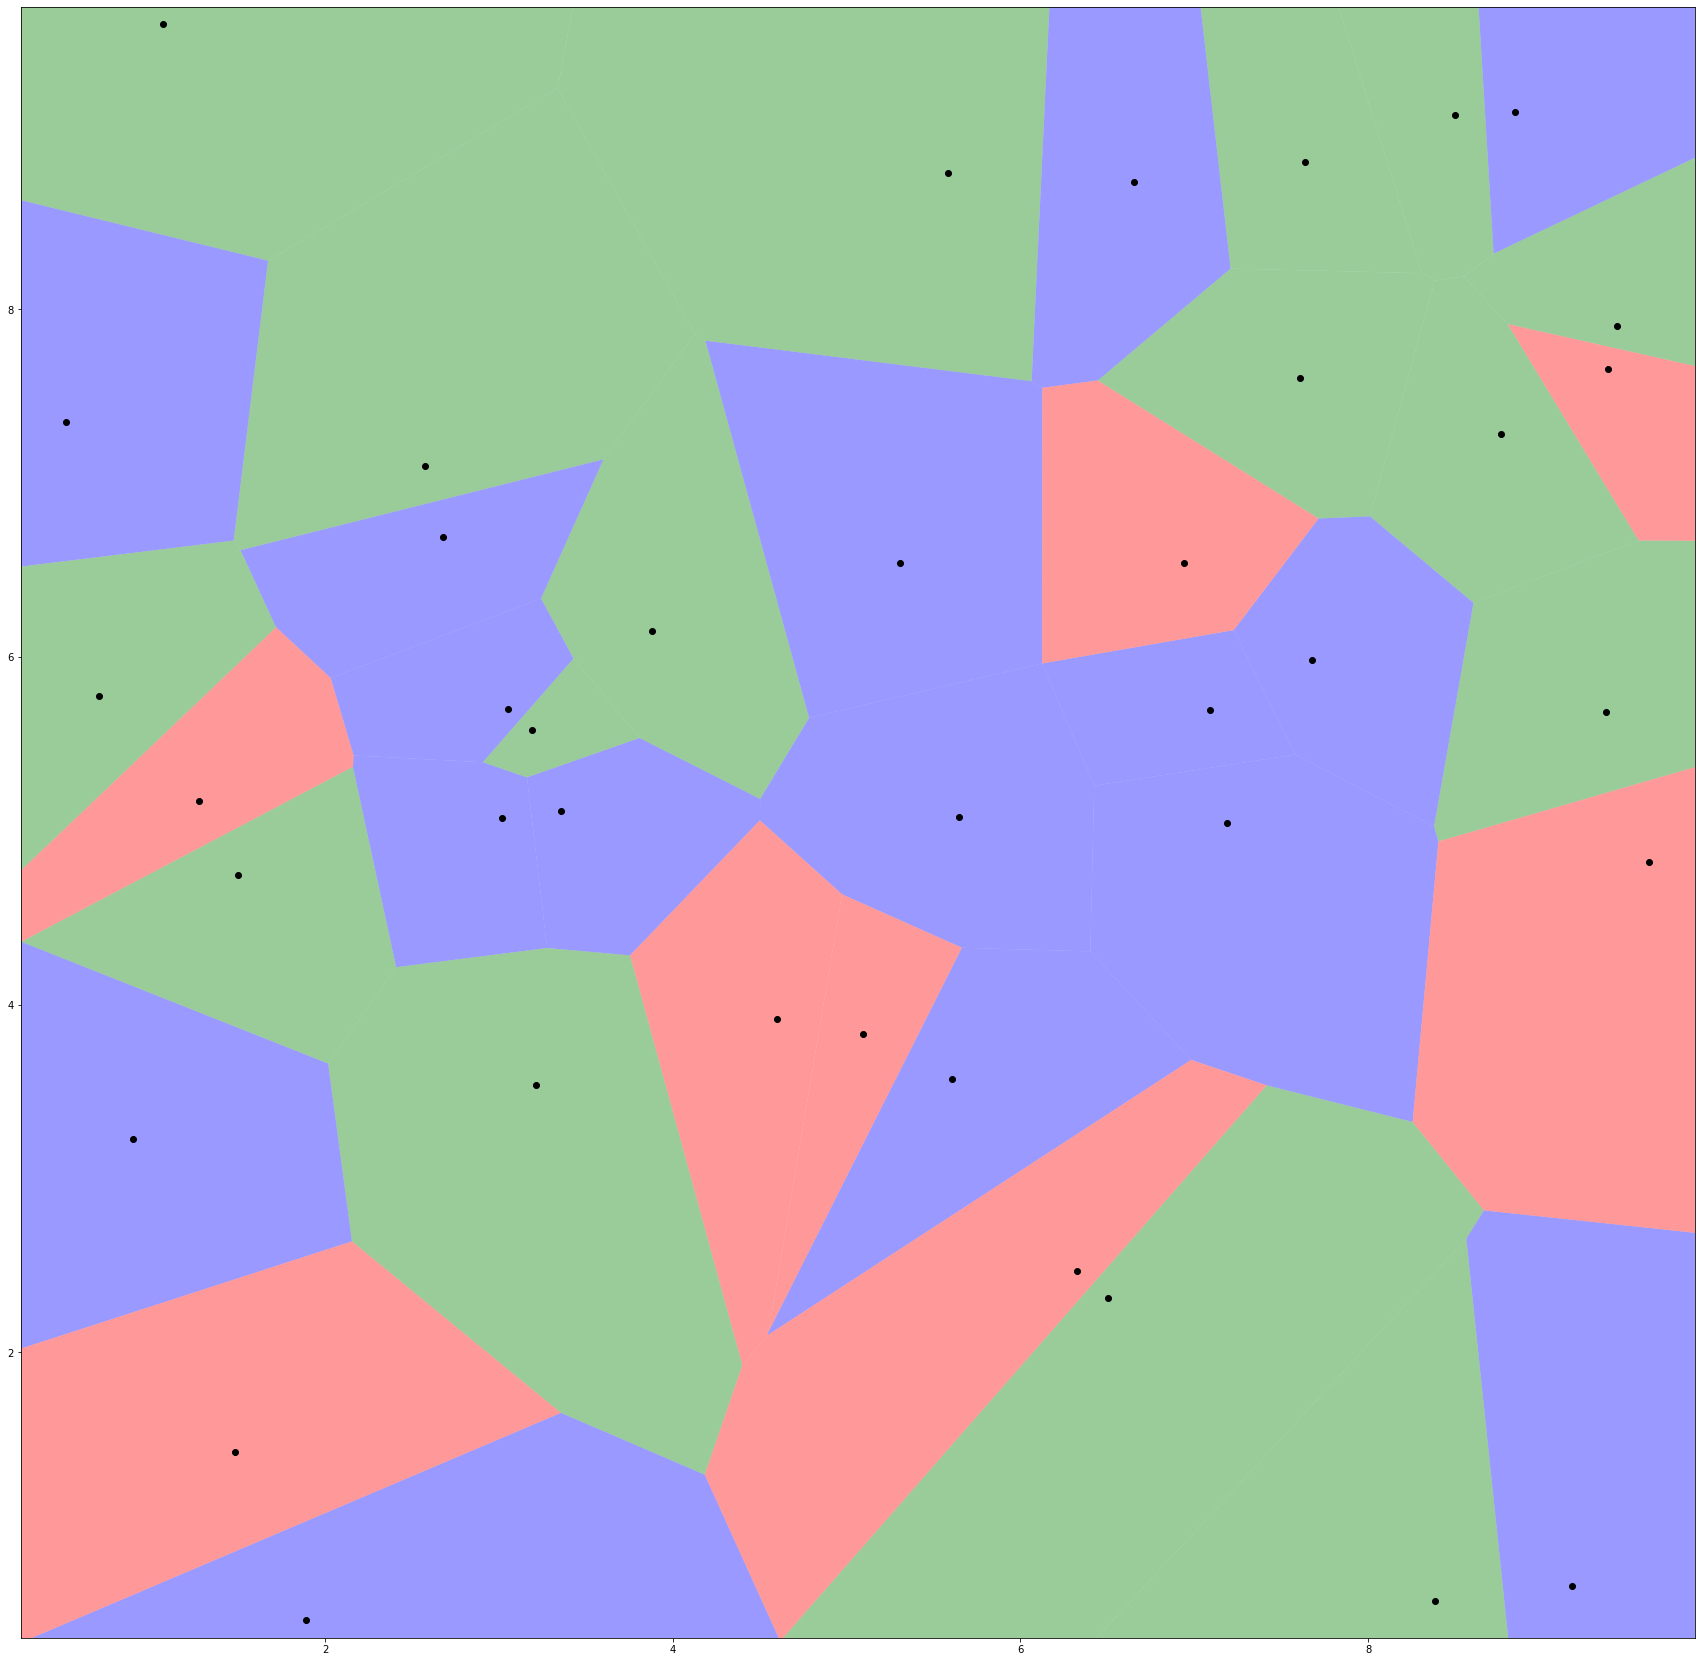

In [0]:
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)
plt.figure(figsize=(30,30))
min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[1] - 0.1
max_y = vor.max_bound[1] + 0.1

# mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
# bounded_vertices = np.max((vertices, mins), axis=0)
# maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
# bounded_vertices = np.min((bounded_vertices, maxs), axis=0)



box = Polygon([[-0.1, -0.1], [-.1, 10.1], [10.1, 10.1], [10.1, -0.1],[-0.1,-0.1]])


polygons = []
i=0
# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    polygons.append(poly)

    plt.fill(*zip(*polygon),color_array[i], alpha=0.4)
    i+=1

plt.plot(x, y, 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voro.png')
plt.show()

In [0]:
from shapely.ops import cascaded_union
region1 = cascaded_union(polygons[:16])
region2 = cascaded_union(polygons[16:32])
region3 = cascaded_union(polygons[32:40])

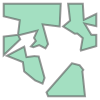

In [0]:
region1

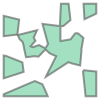

In [0]:
region2

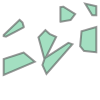

In [0]:
region3

In [0]:
df_gt = geopandas.GeoDataFrame()

In [0]:
df_gt['true class'] = [1,2,3]

In [0]:
df_gt['polygons'] = [region1,region2,region3]
df_gt['true w'] = [[2,5,-3],[-2,1,2],[1,-4,0]]
df_gt['true b'] = [2,0,-1]
df_gt.to_csv('/content/synthetic-groundTruth.csv')

# LOAD GT

In [0]:
import pandas as pd
import numpy as np
df_gt = pd.read_csv('/content/synthetic-groundTruth.csv', index_col=0)

In [6]:
df_gt

,true class,polygons,true w-3D,true b-3D,true w-2D,true b-2D
0,1,MULTIPOLYGON (((8.56566323210442 2.65334146087...,"[2, 5, -3]",2,"1,3",-1
1,2,"MULTIPOLYGON (((-0.1 0.1814478634791331, 3.355...","[-2, 1, 2]",0,"-2,1",5
2,3,"MULTIPOLYGON (((-0.1 1.908078845191928, 2.1539...","[1, -4, 0]",-1,"2,0",2


## Draw random points to make synethic training data

In [0]:
from shapely.wkt import loads
df_gt['polygons'] = df_gt['polygons'].apply(loads)


In [0]:
longitude = np.random.uniform(size=1000)*10
latitude = np.random.uniform(size=1000)*10
df_data = pd.DataFrame()
df_data['longitude'] = longitude
df_data['latitude'] = latitude
df_data['coordinate'] = df_data[['longitude','latitude']].values.tolist()
df_data['coordinate'] = df_data['coordinate'].apply(Point)
points = df_data['coordinate'].values
polygons = df_gt['polygons'].values


z = df_gt['true class'].values
classes = []
for point in points:
  for i in range(len(polygons)):
    if polygons[i].contains(point):
      classes.append(z[i])

df_data ['true class'] = classes

# x = np.random.random(size=(1000,3))
# df_data[['feature1','feature2','feature3']] = pd.DataFrame(x)
x = np.random.random(size=(1000,2))
df_data[['feature1','feature2']] = pd.DataFrame(x)




# w_true = np.array([[2,5,-3],[-2,1,2],[1,-4,0]])
# b_true = np.array([2,0,6]).reshape((1,3))

w_true = np.array([[1,-2,2],
                  [3,1,0],])
b_true = np.array([-1,5,2]).reshape((1,3))


result = pd.merge(df_data, df_gt, how='left', on=['true class'])
# df_data = result[['longitude', 'latitude', 'coordinate', 'true class', 'feature1',
#        'feature2', 'feature3', 'true w', 'true b']]
df_data = result[['longitude', 'latitude', 'coordinate', 'true class', 'feature1',
       'feature2']]

df_data = df_data.sort_values(by = 'true class', axis=0)

In [0]:
result.columns

Index(['longitude', 'latitude', 'coordinate', 'true class', 'feature1',
       'feature2', 'polygons', 'true w', 'true b'],
      dtype='object')

In [0]:
df_data['true class'].value_counts()

1    462
2    363
3    175
Name: true class, dtype: int64

In [0]:
# x = np.array(df_data[['feature1','feature2', 'feature3']].values)
x = np.array(df_data[['feature1','feature2']].values)
y_true = np.zeros((1000,1))
y_true[0:462,:] =(x[0:462,:]@w_true[:,0]).reshape(-1,1)+ b_true[:,0]
y_true[462:825,:] = (x[462:825,:]@w_true[:,1]).reshape(-1,1)+b_true[:,1]
y_true[825:,:] = (x[825:,:]@w_true[:,2]).reshape(-1,1)+b_true[:,2]
y_noisy = y_true + np.random.normal(scale=.1, size=y_true.shape)
df_data['true target'] = y_true
df_data['noisy target'] = y_noisy

# df_data.to_csv('synthetic-3C3D.csv')
df_data.to_csv('synthetic-3C2D.csv')

#Draw random points to make synethetic testing data

In [0]:
longitude = np.random.uniform(size=200)*10
latitude = np.random.uniform(size=200)*10
df_data = pd.DataFrame()
df_data['longitude'] = longitude
df_data['latitude'] = latitude
df_data['coordinate'] = df_data[['longitude','latitude']].values.tolist()
df_data['coordinate'] = df_data['coordinate'].apply(Point)
points = df_data['coordinate'].values
polygons = df_gt['polygons'].values
z = df_gt['true class'].values
classes = []
for point in points:
  for i in range(len(polygons)):
    if polygons[i].contains(point):
      classes.append(z[i])
df_data ['true class'] = classes
x = np.random.random(size=(200,2))
df_data[['feature1','feature2']] = pd.DataFrame(x)
w_true = np.array([[1,-2,2],
                  [3,1,0],])
b_true = np.array([-1,5,2]).reshape((1,3))
result = pd.merge(df_data, df_gt, how='left', on=['true class'])
df_data = result[['longitude', 'latitude', 'coordinate', 'true class', 'feature1',
       'feature2']]
df_data = df_data.sort_values(by = 'true class', axis=0)
x = np.array(df_data[['feature1','feature2']].values)

In [9]:
df_data['true class'].value_counts()

1    101
2     67
3     32
Name: true class, dtype: int64

In [0]:
y_true = np.zeros((200,1))
y_true[0:101,:] =(x[0:101,:]@w_true[:,0]).reshape(-1,1)+ b_true[:,0]
y_true[101:168,:] = (x[101:168,:]@w_true[:,1]).reshape(-1,1)+b_true[:,1]
y_true[168:,:] = (x[168:,:]@w_true[:,2]).reshape(-1,1)+b_true[:,2]
y_noisy = y_true + np.random.normal(scale=.1, size=y_true.shape)
df_data['true target'] = y_true
df_data['noisy target'] = y_noisy
df_data.to_csv('synthetic-3C2D-test.csv')